In [4]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pymc
import pymc as pm
import pytensor
import pytensor.tensor as pt
#import pymc.sampling_jax
# import numpyro
# import blackjax
# import jax
# import arviz as az

# sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso

#statsmodels
import statsmodels.graphics.tsaplots as smg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import statsmodels.formula.api as smf


# warnings
import warnings
warnings.filterwarnings("ignore")

# plots
settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

In [5]:
def readdata():
    data = pd.read_csv(r'../data/hugo_data.csv', index_col=[0], date_format="mm/dd/yyyy")
    return data

raw_data = readdata()
print(raw_data)
print(raw_data.info())

           Start-ups      GDP         U     NAIRU  Job_vacancy        HICP  \
1/1/2006         NaN  179.989  6.433333  4.869898          NaN   86.326667   
4/1/2006         NaN  182.917  6.133333  4.877819          NaN   87.216667   
7/1/2006         NaN  183.853  5.933333  4.885739          NaN   87.123333   
10/1/2006        NaN  185.449  5.866667  4.893660          NaN   87.276667   
1/1/2007     46865.0  187.544  5.633333  4.936292          NaN   87.610000   
...              ...      ...       ...       ...          ...         ...   
4/1/2023     66970.0  234.334  3.466667  4.036260          5.0  128.120000   
7/1/2023     64570.0  233.457  3.633333  3.957463          4.8  129.320000   
10/1/2023    61245.0  234.031  3.566667  3.878666          4.7  128.356667   
1/1/2024     57750.0  233.302  3.633333  3.799049          4.6  129.153333   
4/1/2024     60065.0  235.674  3.633333  3.719431          4.6  131.796667   

           Cao-wages per hour  Borrowing_costs  Credit_standard

In [17]:
data = raw_data[['Start-ups', 
          'GDP', 
          'Job_vacancy',
          'Loans',
          'Zelfstandigenaftrek',
          'Cao-wages per hour',
          'U',
          'NAIRU',
          'Borrowing_costs',
          'Credit_standard'
          ]]

data.to_csv("tmp.csv")

In [144]:
data

,Start-ups,GDP,Job_vacancy,Loans,Zelfstandigenaftrek,Cao-wages per hour,U,NAIRU
1/1/2006,NaN,179.989,NaN,185.370333,6500,77.538897,6.433333,4.869898
4/1/2006,NaN,182.917,NaN,191.778333,6500,77.850071,6.133333,4.877819
7/1/2006,NaN,183.853,NaN,193.400333,6500,78.161245,5.933333,4.885739
10/1/2006,NaN,185.449,NaN,207.998667,6500,78.161245,5.866667,4.893660
1/1/2007,46865.0,187.544,NaN,230.103000,6500,78.868458,5.633333,4.936292
...,...,...,...,...,...,...,...,...
4/1/2023,66970.0,234.334,5.0,354.648667,5030,110.833333,3.466667,4.036260
7/1/2023,64570.0,233.457,4.8,355.830667,5030,112.666667,3.633333,3.957463
10/1/2023,61245.0,234.031,4.7,364.335333,5030,113.633333,3.566667,3.878666
1/1/2024,57750.0,233.302,4.6,365.155667,3750,117.233333,3.633333,3.799049


### Transformations

In [18]:
# one at a time
#data.dropna(inplace=True)

data['Start_ups_percent'] = 100*(np.log(data['Start-ups']).diff(4))
data['GDP_percent_lag']  = 100*((np.log(data['GDP'])).diff(4)).shift(1)
data['Job_vacancy_lag']  = data['Job_vacancy'].shift(1)
data['Loans_lag']  = data['Loans'].shift(1)
data['U_NAIRU_diff'] = data['U'].shift(4) - data['NAIRU'].shift(2)
data['Zelfstandigenaftrek_percent_lag']  = data['Zelfstandigenaftrek'].shift(2)
data['Cao_wages_per_hour_percent_lag'] = 100*(np.log(data['Cao-wages per hour']).diff(4)).shift(2)
data['Borrowing_costs'] = data['Borrowing_costs'].shift(2)
data.head(10)


,Start-ups,GDP,Job_vacancy,Loans,Zelfstandigenaftrek,Cao-wages per hour,U,NAIRU,Borrowing_costs,Credit_standard,Start_ups_percent,GDP_percent_lag,Job_vacancy_lag,Loans_lag,U_NAIRU_diff,Zelfstandigenaftrek_percent_lag,Cao_wages_per_hour_percent_lag
1/1/2006,NaN,179.989,NaN,185.370333,6500,77.538897,6.433333,4.869898,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4/1/2006,NaN,182.917,NaN,191.778333,6500,77.850071,6.133333,4.877819,NaN,0,NaN,NaN,NaN,185.370333,NaN,NaN,NaN
7/1/2006,NaN,183.853,NaN,193.400333,6500,78.161245,5.933333,4.885739,3.933333,-20,NaN,NaN,NaN,191.778333,NaN,6500.0,NaN
10/1/2006,NaN,185.449,NaN,207.998667,6500,78.161245,5.866667,4.893660,4.046667,20,NaN,NaN,NaN,193.400333,NaN,6500.0,NaN
1/1/2007,46865.0,187.544,NaN,230.103000,6500,78.868458,5.633333,4.936292,4.320000,20,NaN,NaN,NaN,207.998667,1.547594,6500.0,NaN
4/1/2007,50110.0,188.697,NaN,236.345000,6500,79.264498,5.266667,4.978923,4.703333,0,NaN,4.111775,NaN,230.103000,1.239673,6500.0,NaN
7/1/2007,43325.0,190.776,NaN,244.364333,6500,79.915134,5.233333,5.021555,4.776667,0,NaN,3.111006,NaN,236.345000,0.997042,6500.0,1.700168
10/1/2007,35945.0,193.551,NaN,256.056000,6500,80.028289,5.066667,5.064187,5.040000,60,NaN,3.696344,NaN,244.364333,0.887743,6500.0,1.800553
1/1/2008,33460.0,194.907,3.4,274.882667,6500,81.188119,4.800000,5.094126,5.286667,60,-33.692043,4.276113,NaN,256.056000,0.611778,6500.0,2.219132
4/1/2008,47585.0,195.047,3.4,290.752000,6500,81.951909,4.800000,5.124065,5.383333,60,-5.170300,3.850904,3.4,274.882667,0.202480,6500.0,2.360625


<Axes: >

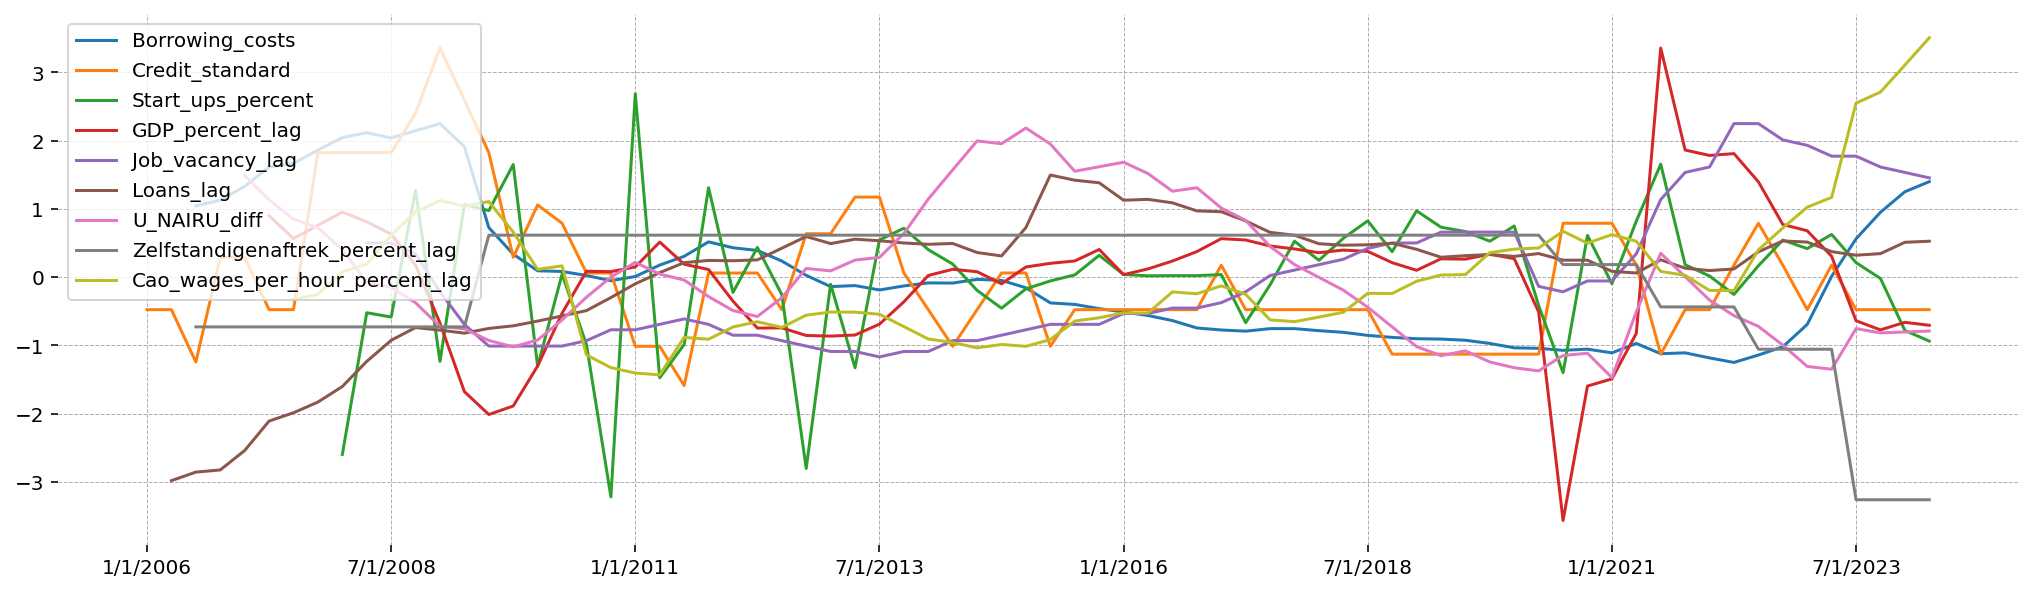

In [21]:
hugo1 = data.iloc[:, 8:]
hugo_stdz = (hugo1 - hugo1.mean())/hugo1.std()
hugo_stdz.plot()    


In [147]:

data3 = data.dropna()

data3 = data3.iloc[24:,]

results = smf.ols("Start_ups_percent ~ 1 + GDP_percent_lag + Job_vacancy_lag  + U_NAIRU_diff + Cao_wages_per_hour_percent_lag", data=data3).fit(cov_type='HAC',cov_kwds={'maxlags':1})

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Start_ups_percent   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     33.72
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           6.97e-11
Time:                        10:45:55   Log-Likelihood:                -105.37
No. Observations:                  36   AIC:                             220.7
Df Residuals:                      31   BIC:                             228.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

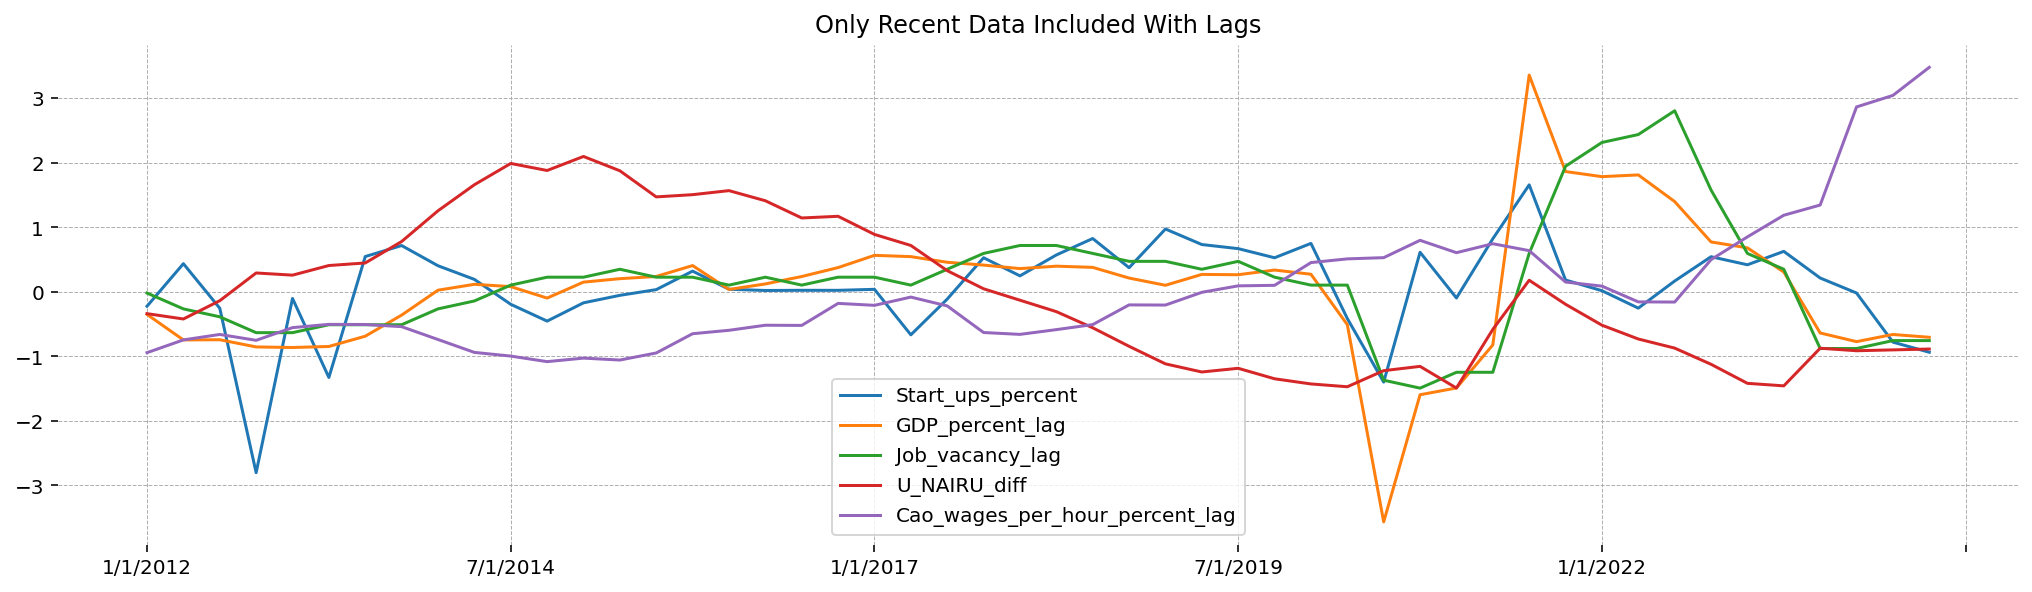

In [148]:
hugo_stdz.iloc[24:,:].plot(title="Only Recent Data Included With Lags")
plt.savefig("../output/Only Recent Data Included With Lags")